In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt

In [48]:
hw2data_raw_data = pd.read_csv('hw2data.csv',delimiter = ',',header = None)
hw2data_raw_data.columns = ['x_1', 'x_2',"y"]
np.random.seed(5525)
reo_list=list(hw2data_raw_data.index)
np.random.shuffle(reo_list)
ave_len_5 = int(len(reo_list)/5)
testing_data = hw2data_raw_data.iloc[reo_list[0:ave_len_5]]
remain_data = hw2data_raw_data.iloc[reo_list[ave_len_5:5*ave_len_5]]
remain_data.head()

reo_list_2=list(remain_data.index)
ave_len_10 = int(len(reo_list_2)/10)
index_1 = reo_list_2[0:ave_len_10]
index_2 = reo_list_2[ave_len_10:2*ave_len_10]
index_3 = reo_list_2[2*ave_len_10:3*ave_len_10]
index_4 = reo_list_2[3*ave_len_10:4*ave_len_10]
index_5 = reo_list_2[4*ave_len_10:5*ave_len_10]
index_6 = reo_list_2[5*ave_len_10:6*ave_len_10]
index_7 = reo_list_2[6*ave_len_10:7*ave_len_10]
index_8 = reo_list_2[7*ave_len_10:8*ave_len_10]
index_9 = reo_list_2[8*ave_len_10:9*ave_len_10]
index_10 = reo_list_2[9*ave_len_10:10*ave_len_10]

X_shuffled = {0:hw2data_raw_data.iloc[index_1].loc[:,["x_1","x_2"]],1:hw2data_raw_data.iloc[index_2].loc[:,["x_1","x_2"]],2:hw2data_raw_data.iloc[index_3].loc[:,["x_1","x_2"]],3:hw2data_raw_data.iloc[index_4].loc[:,["x_1","x_2"]],4:hw2data_raw_data.iloc[index_5].loc[:,["x_1","x_2"]],+
              5:hw2data_raw_data.iloc[index_6].loc[:,["x_1","x_2"]],6:hw2data_raw_data.iloc[index_7].loc[:,["x_1","x_2"]],7:hw2data_raw_data.iloc[index_8].loc[:,["x_1","x_2"]],8:hw2data_raw_data.iloc[index_9].loc[:,["x_1","x_2"]],9:hw2data_raw_data.iloc[index_10].loc[:,["x_1","x_2"]]}
y_shuffled = {0:hw2data_raw_data.iloc[index_1].loc[:,"y"],1:hw2data_raw_data.iloc[index_2].loc[:,"y"],2:hw2data_raw_data.iloc[index_3].loc[:,"y"],3:hw2data_raw_data.iloc[index_4].loc[:,"y"],4:hw2data_raw_data.iloc[index_5].loc[:,"y"],+
             5:hw2data_raw_data.iloc[index_6].loc[:,"y"],6:hw2data_raw_data.iloc[index_7].loc[:,"y"],7:hw2data_raw_data.iloc[index_8].loc[:,"y"],8:hw2data_raw_data.iloc[index_9].loc[:,"y"],9:hw2data_raw_data.iloc[index_10].loc[:,"y"]}
X_test = remain_data.loc[:,["x_1","x_2"]]
y_test = remain_data.loc[:,"y"]

In [3]:
def get_next_train_valid(X_shuffled, y_shuffled, itr):
    """
    - itr value can tell you which fold you pick up for valid and rest go to training
    - use 1 fold for validation and all other folds for training
    - in next iteration, use a different fold for validation and remaining folds for training
        
    Basically, here you will determine which fold goes for validation and which ones for training
    """
    X_valid = pd.DataFrame(X_shuffled.get(itr))
    y_valid = pd.DataFrame(y_shuffled.get(itr))
    X_train = pd.DataFrame()
    y_train = pd.DataFrame()
    for i in range(10):
        if (i != itr):
            X_train = pd.concat([X_train,X_shuffled.get(i)],axis = 0)
            y_train = pd.concat([y_train,y_shuffled.get(i)],axis = 0)
    return(X_train,y_train,X_valid,y_valid)
    #return training and validation data

In [59]:
def Kernel_fun(x1,x2,type):
    if(type == 'linear'):
        return np.dot(x1, x2)
    if(type == 'rbf'):
        dist = np.linalg.norm(x1 - x2) ** 2
        return np.exp(-dist/(2 * (2 ** 2)))

In [36]:
def svmfit(X_train, y_train, Ktype, bigC = 1):
    """
    This function should implement fitting or training your model in question. 
    """
    rnum = X_train.shape[0]
    cnum = X_train.shape[1]
    tmp_K = np.zeros((rnum, rnum))
    for i in range(rnum):
        for j in range(rnum):
            tmp_K[i, j] = Kernel_fun(X_train[i],X_train[j],Ktype)
    P = np.outer(y_train, y_train) * tmp_K
    q = -1 * np.ones((rnum,1))
    G = np.vstack((np.eye(rnum)* -1 ,np.eye(rnum)))
    h = np.hstack((np.zeros(rnum), np.ones(rnum) * bigC))
    A = y_train.T
    b = np.array([0.0])
    
    P_cvm = cvxopt.matrix(P)
    q_cvm = cvxopt.matrix(q)
    G_cvm = cvxopt.matrix(G)
    h_cvm = cvxopt.matrix(h)
    A_cvm = cvxopt.matrix(A)
    b_cvm = cvxopt.matrix(b)
    sol=cvxopt.solvers.qp(P_cvm, q_cvm, G_cvm, h_cvm, A_cvm, b_cvm,solver='glpk',options={'glpk':{'msg_lev':'GLP_MSG_OFF'}})
    lamb = np.array(sol['x'])
    w = np.zeros(cnum,)
    for i in range(0, rnum):
        if (sol["x"][i]>=0 and sol["x"][i]<=bigC):
            w = w + np.multiply(y_t[i][0]*sol["x"][i],list(X_t[i]))
    S = (lamb > 1e-5).flatten()
    b = y_train[S] - np.dot(X_train[S], w)
    model = (w,b[0][0])
    return model
    # return model

In [6]:
def linear_svm_train(X_train, y_train, bigC = 1):
    return svmfit(X_train, y_train, 'linear', bigC)

In [7]:
def rbf_svm_train(X_train, y_train, bigC = 1):
    return svmfit(X_train, y_train, 'rbf', bigC)

In [8]:
def predict(X_valid, model):
    """
    Here, using the trained model, implement how to predict when you just have feature vector. 
    """
    w = model[0]
    b = model[1]
    y_predicted = np.sign(np.dot(X_valid,w) + b)
    return y_predicted
    # return 

In [60]:
"""
Main - Here goes the overall logic.
"""
# cross-validation to get train and validation data
# We will use cross validation for training and validation. In this assignment, we will not use test split separately.
#  Let us say we want k-fold with k=5 - shuffle the data and partition into k-equal partitions
#  Save paritions into dictionaries

#Loop through 5 times, each time selecting 1 fold as validation and remaining as train data sets using function get_next_train_valid 
#   train your model
#   predict target on validation and training
#   compute error i.e. RMSE or classification accuracy as per assignment question
#
#Plot or print as per question - Mean RMSE or accuracy

linear_Validation_Error_Rate_list = []
linear_Testing_Error_Rate_list = []
RBF_Validation_Error_Rate_list = []
RBF_Testing_Error_Rate_list = []
model_list = []

for itr in range(10):
    X_t = get_next_train_valid(X_shuffled, y_shuffled, itr)[0]
    X_t = np.array(X_t)
    y_t = get_next_train_valid(X_shuffled, y_shuffled, itr)[1]
    y_t = np.array(y_t)
    X_v = get_next_train_valid(X_shuffled, y_shuffled, itr)[2]
    X_v = np.array(X_v)
    y_v = get_next_train_valid(X_shuffled, y_shuffled, itr)[3]
    y_v = np.array(y_v)
    model = linear_svm_train(X_t,y_t)
    L_y_p_v = predict(X_v,model)
    L_ero_v = 1-(sum(L_y_p_v == y_v.T[0])/L_y_p_v.shape[0])
    linear_Validation_Error_Rate_list.append(L_ero_v)
    L_y_t_t = predict(X_test,model)
    L_ero_t_t = 1-(sum(L_y_t_t == (np.array(y_test).T)[0])/L_y_t_t.shape[0])
    linear_Testing_Error_Rate_list.append(L_ero_t_t)
    
    model = rbf_svm_train(X_t,y_t)
    R_y_p_v = predict(X_v,model)
    R_ero_v = 1-(sum(R_y_p_v == y_v.T[0])/R_y_p_v.shape[0])
    RBF_Validation_Error_Rate_list.append(R_ero_v)
    
    R_y_t_t = predict(X_test,model)
    R_ero_t_t = 1-(sum(R_y_t_t == (np.array(y_test).T)[0])/R_y_t_t.shape[0])
    RBF_Testing_Error_Rate_list.append(R_ero_t_t)


     pcost       dcost       gap    pres   dres
 0: -1.4384e+03 -3.0828e+03  7e+03  2e+00  4e-14
 1: -1.1564e+03 -2.0954e+03  9e+02  2e-14  3e-14
 2: -1.3442e+03 -1.5591e+03  2e+02  1e-14  2e-14
 3: -1.3689e+03 -1.4952e+03  1e+02  3e-14  2e-14
 4: -1.3759e+03 -1.4817e+03  1e+02  7e-15  2e-14
 5: -1.3857e+03 -1.4622e+03  8e+01  1e-14  2e-14
 6: -1.3983e+03 -1.4422e+03  4e+01  2e-14  2e-14
 7: -1.4100e+03 -1.4241e+03  1e+01  2e-15  3e-14
 8: -1.4135e+03 -1.4195e+03  6e+00  1e-14  2e-14
 9: -1.4153e+03 -1.4172e+03  2e+00  2e-14  2e-14
10: -1.4158e+03 -1.4165e+03  7e-01  4e-15  2e-14
11: -1.4160e+03 -1.4163e+03  2e-01  2e-14  3e-14
12: -1.4161e+03 -1.4161e+03  4e-03  1e-14  3e-14
13: -1.4161e+03 -1.4161e+03  4e-05  7e-15  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.0985e+02 -3.3449e+03  1e+04  3e+00  1e-14
 1: -4.1064e+02 -2.2533e+03  3e+03  3e-01  8e-15
 2: -3.6298e+02 -6.5690e+02  3e+02  8e-03  1e-14
 3: -4.7456e+02 -5.3775e+02  7e+01  1e-03  8e-1

10: -5.0623e+02 -5.0623e+02  2e-03  1e-14  9e-15
11: -5.0623e+02 -5.0623e+02  2e-05  2e-15  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4382e+03 -3.0865e+03  7e+03  2e+00  4e-14
 1: -1.1554e+03 -2.0980e+03  9e+02  9e-15  3e-14
 2: -1.3372e+03 -1.5690e+03  2e+02  2e-14  2e-14
 3: -1.3639e+03 -1.4913e+03  1e+02  1e-14  2e-14
 4: -1.3697e+03 -1.4779e+03  1e+02  4e-15  2e-14
 5: -1.3796e+03 -1.4582e+03  8e+01  2e-14  3e-14
 6: -1.3968e+03 -1.4286e+03  3e+01  2e-16  3e-14
 7: -1.4048e+03 -1.4099e+03  5e+00  5e-15  3e-14
 8: -1.4060e+03 -1.4061e+03  1e-01  2e-15  3e-14
 9: -1.4060e+03 -1.4060e+03  1e-03  2e-14  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.0147e+02 -3.3356e+03  1e+04  3e+00  1e-14
 1: -4.0808e+02 -2.2636e+03  3e+03  4e-01  7e-15
 2: -3.5350e+02 -6.6436e+02  3e+02  5e-03  7e-15
 3: -4.6564e+02 -5.3407e+02  7e+01  1e-03  7e-15
 4: -4.8299e+02 -5.1980e+02  4e+01  4e-04  6e-15
 5: -4.9430e+02 -5.0934

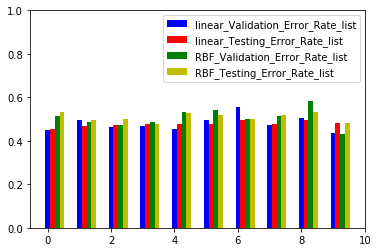

In [61]:
CV_time = ['CV-1', 'CV-2', 'CV-3', 'CV-4', 'CV-5', 'CV-6', 'CV-7','CV-8','CV-9','CV-10']
bar_width = 0.15
plt.ylim(0, 1)
rects1 = plt.bar(x = np.arange(len(CV_time)), height = linear_Validation_Error_Rate_list, color='b',label='linear_Validation_Error_Rate_list',width=bar_width)
rects2 = plt.bar(x = np.arange(len(CV_time))+bar_width, height = linear_Testing_Error_Rate_list, color='r',label='linear_Testing_Error_Rate_list',width=bar_width)
rects3 = plt.bar(x = np.arange(len(CV_time))+2*bar_width, height = RBF_Validation_Error_Rate_list, color='g',label='RBF_Validation_Error_Rate_list',width=bar_width)
rects4 = plt.bar(x = np.arange(len(CV_time))+3*bar_width, height = RBF_Testing_Error_Rate_list, color='y',label='RBF_Testing_Error_Rate_list',width=bar_width)
plt.legend(loc=0,ncol=1)
plt.show()